In [3]:
%cd ..

e:\ybii\github\YbII


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from src.functions.math import func as mathf
from src.functions.optics import func as optf
from src.constants import const

In [5]:
import magpylib as magpy
from magpylib.current import Loop

In [6]:
def mot3d_coil(I=200, config="H", plot_obj=False):

    if config=="H":
        curr_up = -I
        curr_down = -I
    else:
        if config=="AH":
            curr_up = -I
            curr_down = I
        else:
            raise ValueError("Invalid 3D MOT Coil Configuration")

    # Turns
    T = 9
    # Windings
    W = 8

    # Spacing between windings
    s = 5.588 # in mm
    
    # Width of coil
    L = T * (6) # in mm

    # Diameter
    # d - Inner diameter
    d = 273.05 # in mm

    # D - Outer diameter
    D = d + 2 * W * s # in mm
    D = 370.84 # in mm

    # Error
    e = 0 # in mm

    # Position of coils
    z_1 = 92.6225 + e
    z_2 = -z_1

    coil = magpy.Collection()

    for i in range(0, 2*T, 2):
        for n in range(W):

            # Upper Coils
            winding1 = magpy.current.Circle(
                current = curr_up,
                diameter = d + (2*n + 1) * s,
                position = (0, 0, z_1 + (s)*((i - (T-1))/2)),
            )

            coil.add(winding1)

            # Lower Coils
            winding2 = magpy.current.Circle(
                current = curr_down,
                diameter = d + (2*n + 1) * s,
                position = (0, 0, z_2 + (s)*((i - (T-1))/2)),
            )

            coil.add(winding2)

    if plot_obj:
        coil.show(backend='plotly')

    return coil

In [7]:
coil = mot3d_coil(config="AH", plot_obj=True)

In [8]:
def power_usage(I=200, start=0, end=8, full_obj=True):
  
  rho = const.rho_cu * 10**(3) # in Ohm - mm at 20 C
  d_h = 3.4 # in mm => Quote - 3.6068 mm

  print(rho)
  
  # d - Inner diameter
  d = 273.05 # in mm
  # Spacing between windings
  s = 5.588 # in mm
  # Turns
  T = 9
  # Windings
  W = 8

  # Start and End of Segment
  k, l = start, end
  L_k = 0
  P_k = 0

  for i in range(0, 2*T, 2):
    for n in range(k, l):

      # Power radiated by the upper coils
      current = I
      diameter = d + (2*n + 1) * s

      L_k += np.pi * diameter
      P_k += (I**2) * (rho) * ((np.pi * diameter)/(5.588**2 - np.pi*((d_h**2)/(4))))

  if full_obj:
    L_k = 2 * L_k
    P_k = 2 * P_k

  return [L_k / 10**(3), P_k]

In [9]:
print(power_usage())

1.7e-05
[143.748523015023, 4413.736421867803]


In [16]:
import matplotlib.pyplot as plt

def plot_plane(plane="xy", min=[-100, -100], max=[100, 100], res=100, title="Magnetic Field Streamplot (XY plane)", save_plot=False, fname="mot3d_ah_i_200a", dir="results\\"):

    fig, axs = plt.subplots(1, 1, figsize=(26,10))

    # create grid
    ax1_ts = np.linspace(min[0], max[0], res)
    ax2_ts = np.linspace(min[0], max[1], res)
    comp = [0, 1]

    if plane=="xy":
        grid = np.array([[(x, y, 0) for x in ax1_ts] for y in ax2_ts])
        comp = [0, 1]
    else:
        if plane=="yz":
            grid = np.array([[(0, y, z) for y in ax1_ts] for z in ax2_ts])
            comp = [1, 2]
        else:
            if plane=="xz":
                grid = np.array([[(x, 0, z) for x in ax1_ts] for z in ax2_ts])
                comp = [0, 2]
            else:
                raise ValueError("Invalid Plane")

    # compute and plot field of coil
    B = magpy.getB(coil, grid)
    Bamp = np.linalg.norm(B, axis=2)
    Bamp /= np.amax(Bamp)

    sp = axs.streamplot(
        grid[:,:,comp[0]], grid[:,:,comp[1]], B[:,:,comp[0]], B[:,:,comp[1]],
        density=2,
        color=np.where(np.linalg.norm(B, axis=2) > 100, 1000, 10*np.linalg.norm(B, axis=2)),
        linewidth=np.sqrt(Bamp)*3,
        cmap='jet',
    )

    # figure styling
    axs.set(
        title='Magnetic field of coils [G]',
        xlabel=plane[0] + '-position [mm]',
        ylabel=plane[1] + '-position [mm]',
        aspect=1,
    )

    plt.colorbar(sp.lines, ax=axs, label='[G]')

    if save_plot:
        plt.savefig(dir + fname + '.png', bbox_inches='tight')

    plt.tight_layout()
    plt.show()

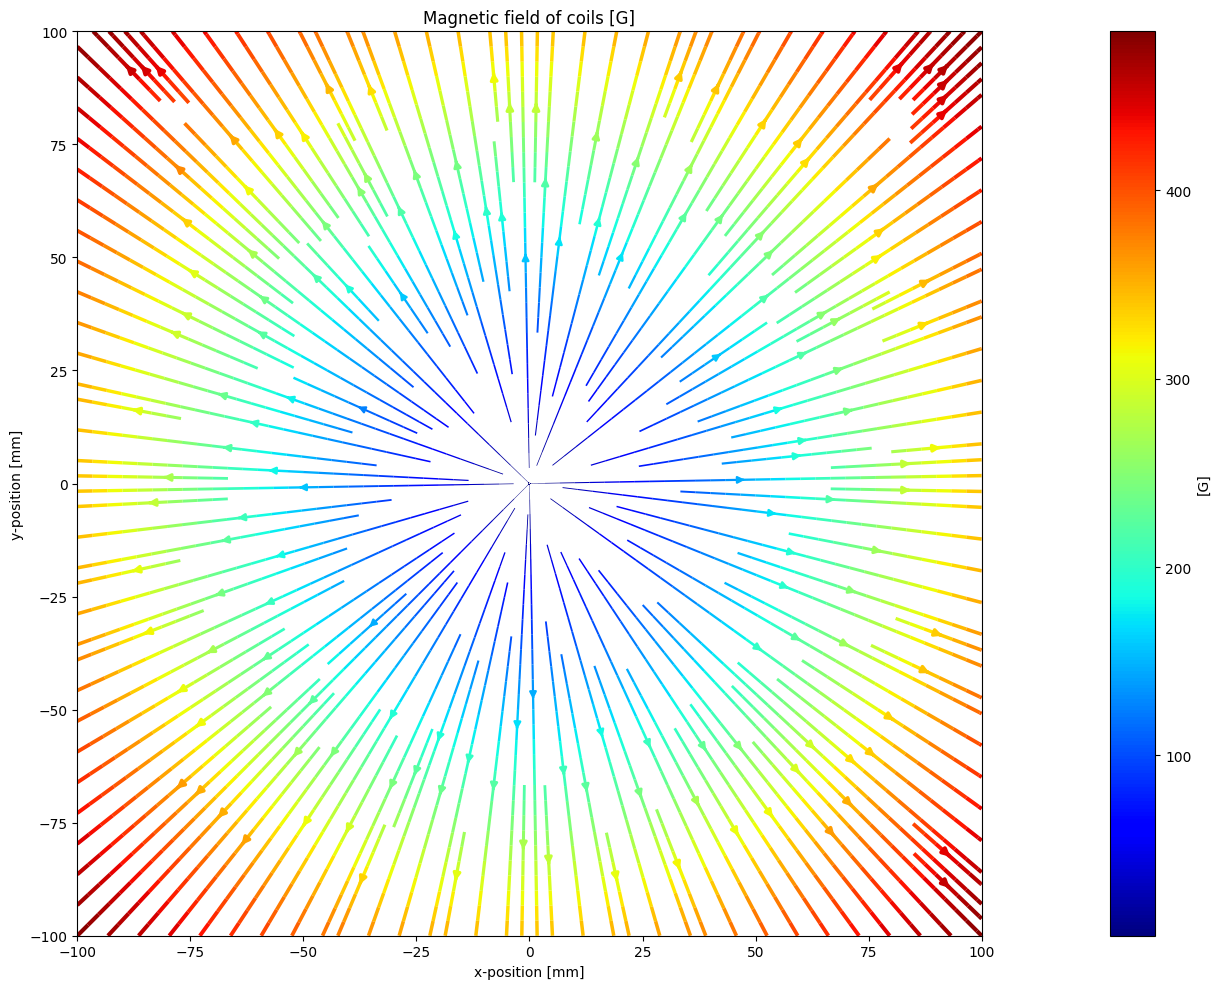

In [20]:
plot_plane(plane="xy", fname="mot3d_ah_i_200a_xy", save_plot=True)